<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID CONTATTO           5098 non-null   int64  
 1   DATA INSERIMENTO      5098 non-null   object 
 2   SESSO                 5098 non-null   object 
 3   IMPORTO RICHIESTO     5098 non-null   int64  
 4   MONTANTE              5098 non-null   int64  
 5   RATA                  5098 non-null   int64  
 6   DURATA                5098 non-null   int64  
 7   REGIONE               5098 non-null   object 
 8   PROVINCIA             5098 non-null   object 
 9   COMUNE                5098 non-null   object 
 10  COMUNE DI NASCITA     5098 non-null   object 
 11  DATA DI NASCITA       5098 non-null   object 
 12  MOTIVAZIONE_PRESTITO  5098 non-null   object 
 13  FONTE                 5098 non-null   object 
 14  STATO CONTATTO        5098 non-null   object 
 15  TIPO OCCUPAZIONE     

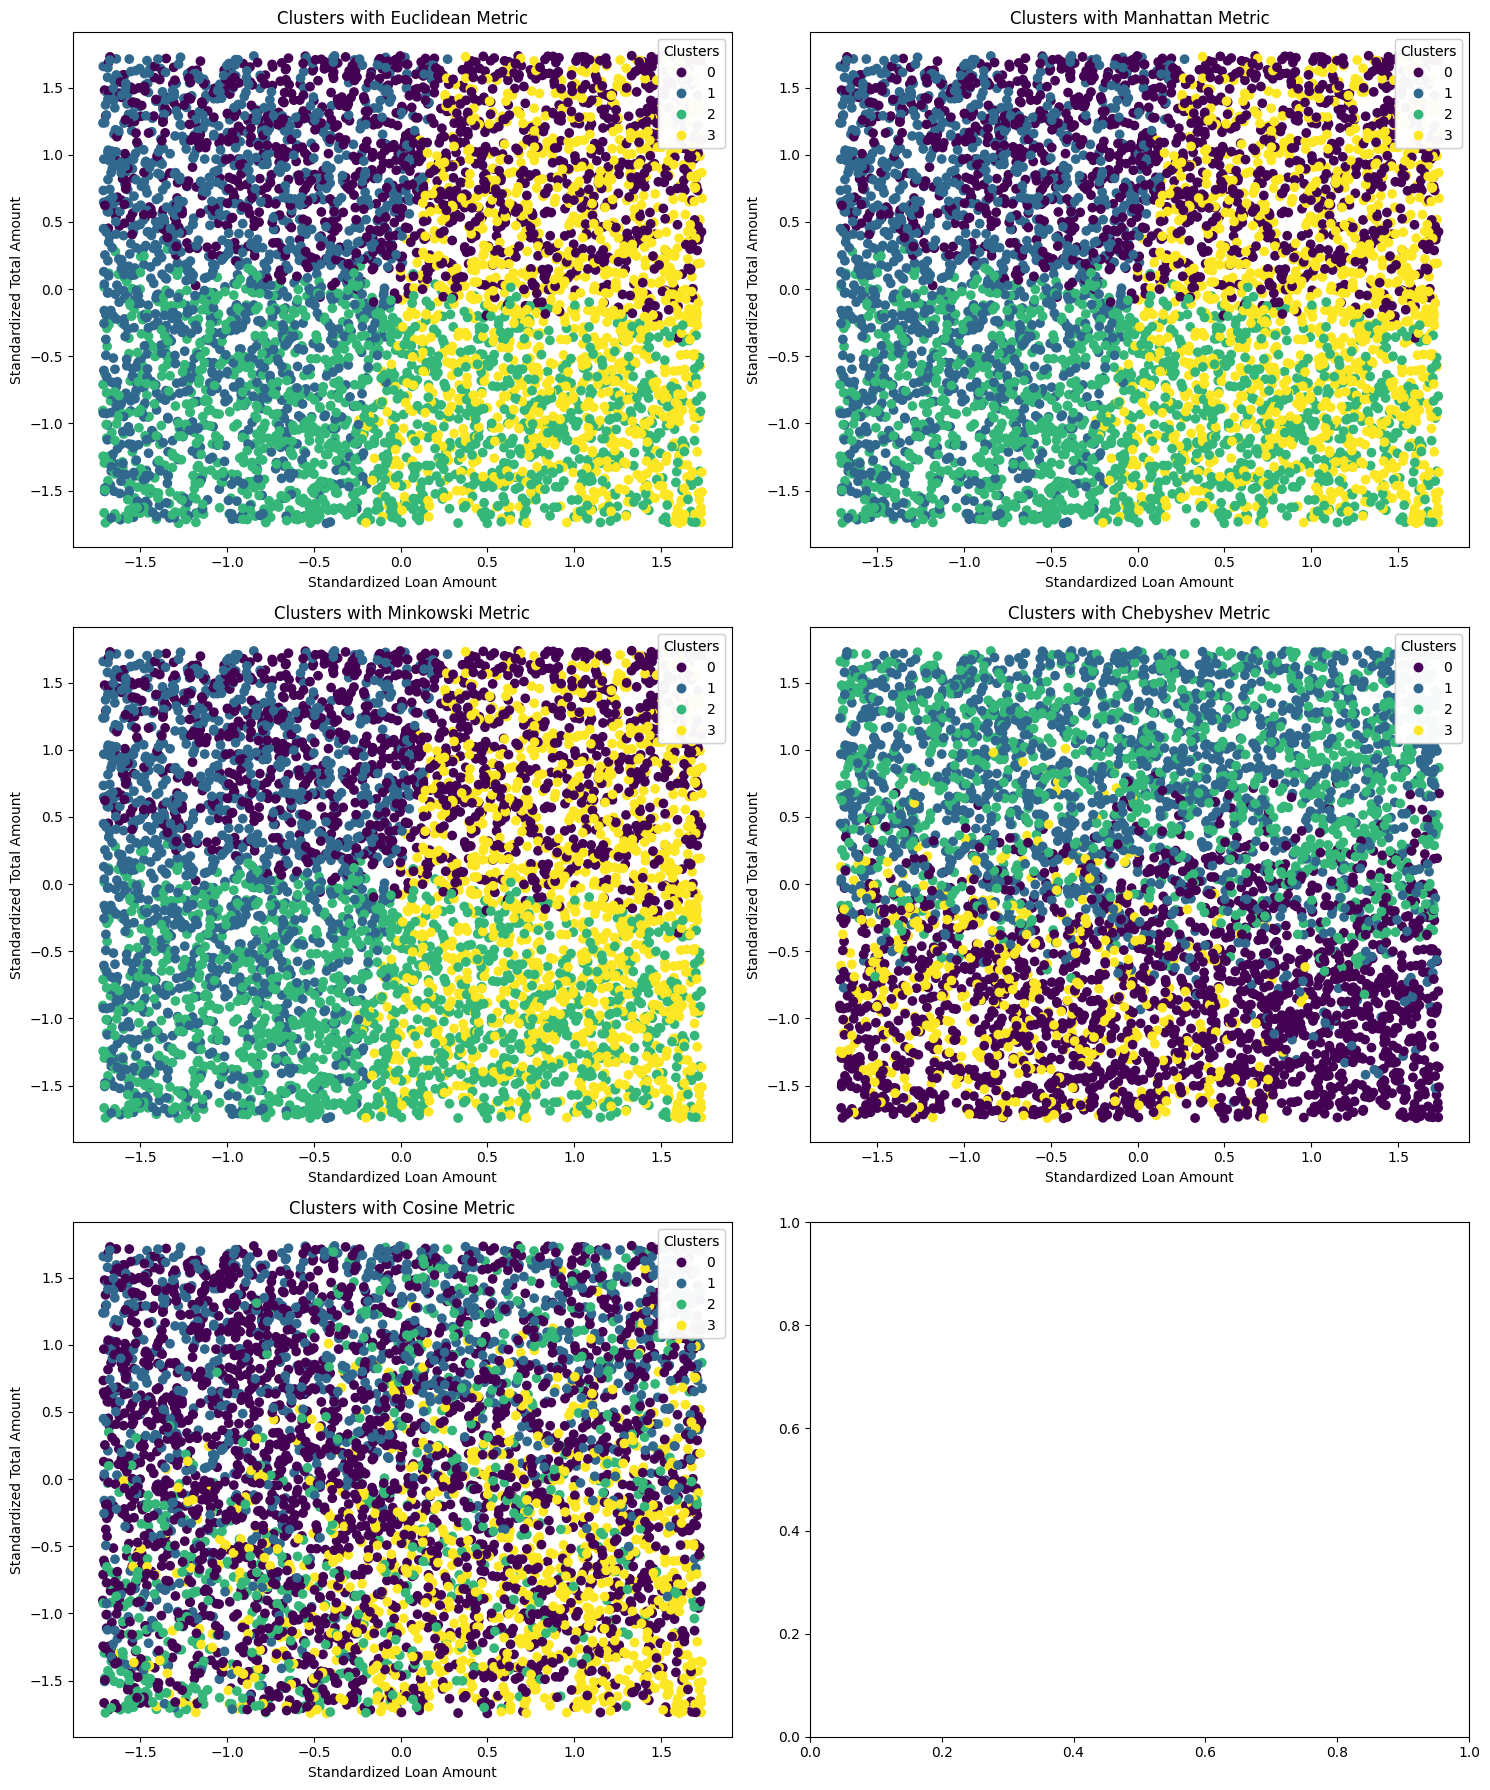

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Path to your CS0V file
# file_path = 'data_simulation_new1.csv'
file_path = 'simulated_data_5000.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Remove leading and trailing spaces in column names
df.columns = df.columns.str.strip()

df.info()


# Select relevant features
features = ['IMPORTO RICHIESTO', 'MONTANTE', 'RATA', 'DURATA', 'STIPENDIO']
df_selected = df[features]

# Handle missing values (if any)
df_selected = df_selected.dropna()

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)


# Function to calculate silhouette score for different metrics


def calculate_silhouette_score(metric):
    if metric in ['euclidean', 'manhattan', 'minkowski']:
        model = KMeans(n_clusters=4, random_state=42)
        labels = model.fit_predict(df_scaled)
    else:
        model = AgglomerativeClustering(
            n_clusters=4, metric=metric, linkage='complete')
        labels = model.fit_predict(df_scaled)

    score = silhouette_score(
        df_scaled, labels, metric=metric if metric != 'mahalanobis' else 'euclidean')
    return score, labels


# Metrics to compare
metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']

# Calculate silhouette scores and cluster labels for each metric
scores = {}
labels_dict = {}
for metric in metrics:
    score, labels = calculate_silhouette_score(metric)
    scores[metric] = score
    labels_dict[metric] = labels

# Display silhouette scores
print("Silhouette Scores for Different Metrics:")
for metric, score in scores.items():
    print(f"{metric.capitalize()}: {score}")

# Plot clusters for each metric
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    scatter = ax.scatter(
        df_scaled[:, 0], df_scaled[:, 1], c=labels_dict[metric], cmap='viridis')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_title(f"Clusters with {metric.capitalize()} Metric")
    ax.set_xlabel('Standardized Loan Amount')
    ax.set_ylabel('Standardized Total Amount')
plt.tight_layout()
plt.show()

Vector DB: metrics comparison

In [2]:
import sqlite3

# Create a new SQLite database (or connect to an existing one)
conn = sqlite3.connect('vector_db.sqlite')
cursor = conn.cursor()

# Create a table to store vectors
cursor.execute('''
CREATE TABLE IF NOT EXISTS vectors (
    id INTEGER PRIMARY KEY,
    x1 REAL,
    x2 REAL,
    x3 REAL
)
''')

# Commit changes and close the connection
conn.commit()

In [3]:
import numpy as np

# Function to generate random vectors


def generate_random_vectors(num_vectors):
    return np.random.rand(num_vectors, 3)


# Generate 100 random vectors
vectors = generate_random_vectors(100)

# Insert vectors into the database
for vector in vectors:
    cursor.execute('''
    INSERT INTO vectors (x1, x2, x3) VALUES (?, ?, ?)
    ''', (vector[0], vector[1], vector[2]))

# Commit changes and close the connection
conn.commit()

In [4]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from scipy.spatial.distance import minkowski, chebyshev, cosine

# Function to fetch all vectors from the database


def fetch_vectors():
    cursor.execute('SELECT x1, x2, x3 FROM vectors')
    return np.array(cursor.fetchall())


# Fetch vectors from the database
vectors = fetch_vectors()

# Choose a reference vector for similarity comparisons (e.g., the first vector)
reference_vector = vectors[0].reshape(1, -1)

# Initialize lists to store similarity and distance values
cosine_similarities = []
euclidean_distances_list = []
manhattan_distances_list = []
minkowski_distances_list = []
chebyshev_distances_list = []
cosine_distances_list = []

# Calculate similarities and distances
for vector in vectors:
    vector_reshaped = vector.reshape(1, -1)
    cosine_similarities.append(cosine_similarity(
        reference_vector, vector_reshaped)[0][0])
    euclidean_distances_list.append(euclidean_distances(
        reference_vector, vector_reshaped)[0][0])
    manhattan_distances_list.append(manhattan_distances(
        reference_vector, vector_reshaped)[0][0])
    minkowski_distances_list.append(
        minkowski(reference_vector.flatten(), vector, p=3))
    chebyshev_distances_list.append(
        chebyshev(reference_vector.flatten(), vector))
    cosine_distances_list.append(cosine(reference_vector.flatten(), vector))

# Display the results for the first few vectors
print("Cosine Similarities:", cosine_similarities[:5])
print("Euclidean Distances:", euclidean_distances_list[:5])
print("Manhattan Distances:", manhattan_distances_list[:5])
print("Minkowski Distances (p=3):", minkowski_distances_list[:5])
print("Chebyshev Distances:", chebyshev_distances_list[:5])
print("Cosine Distances:", cosine_distances_list[:5])

# Close the database connection
conn.close()

Cosine Similarities: [0.9999999999999999, 0.8611351609258908, 0.8269793589330355, 0.8690241595025782, 0.9276205141782543]
Euclidean Distances: [2.1073424255447017e-08, 0.5222396324819929, 0.6324991431929817, 0.5271120032302244, 0.37526630603929506]
Manhattan Distances: [0.0, 0.8286902563301806, 0.9591573430569872, 0.8786955444067207, 0.559333310476831]
Minkowski Distances (p=3): [0.0, 0.4592484774209517, 0.5610912445193663, 0.4526731257863459, 0.33382769565420106]
Chebyshev Distances: [0.0, 0.39646753245396626, 0.4681986813402831, 0.3819071598249094, 0.27965632086104186]
Cosine Distances: [0, 0.13886483907410907, 0.17302064106696446, 0.13097584049742161, 0.07237948582174558]


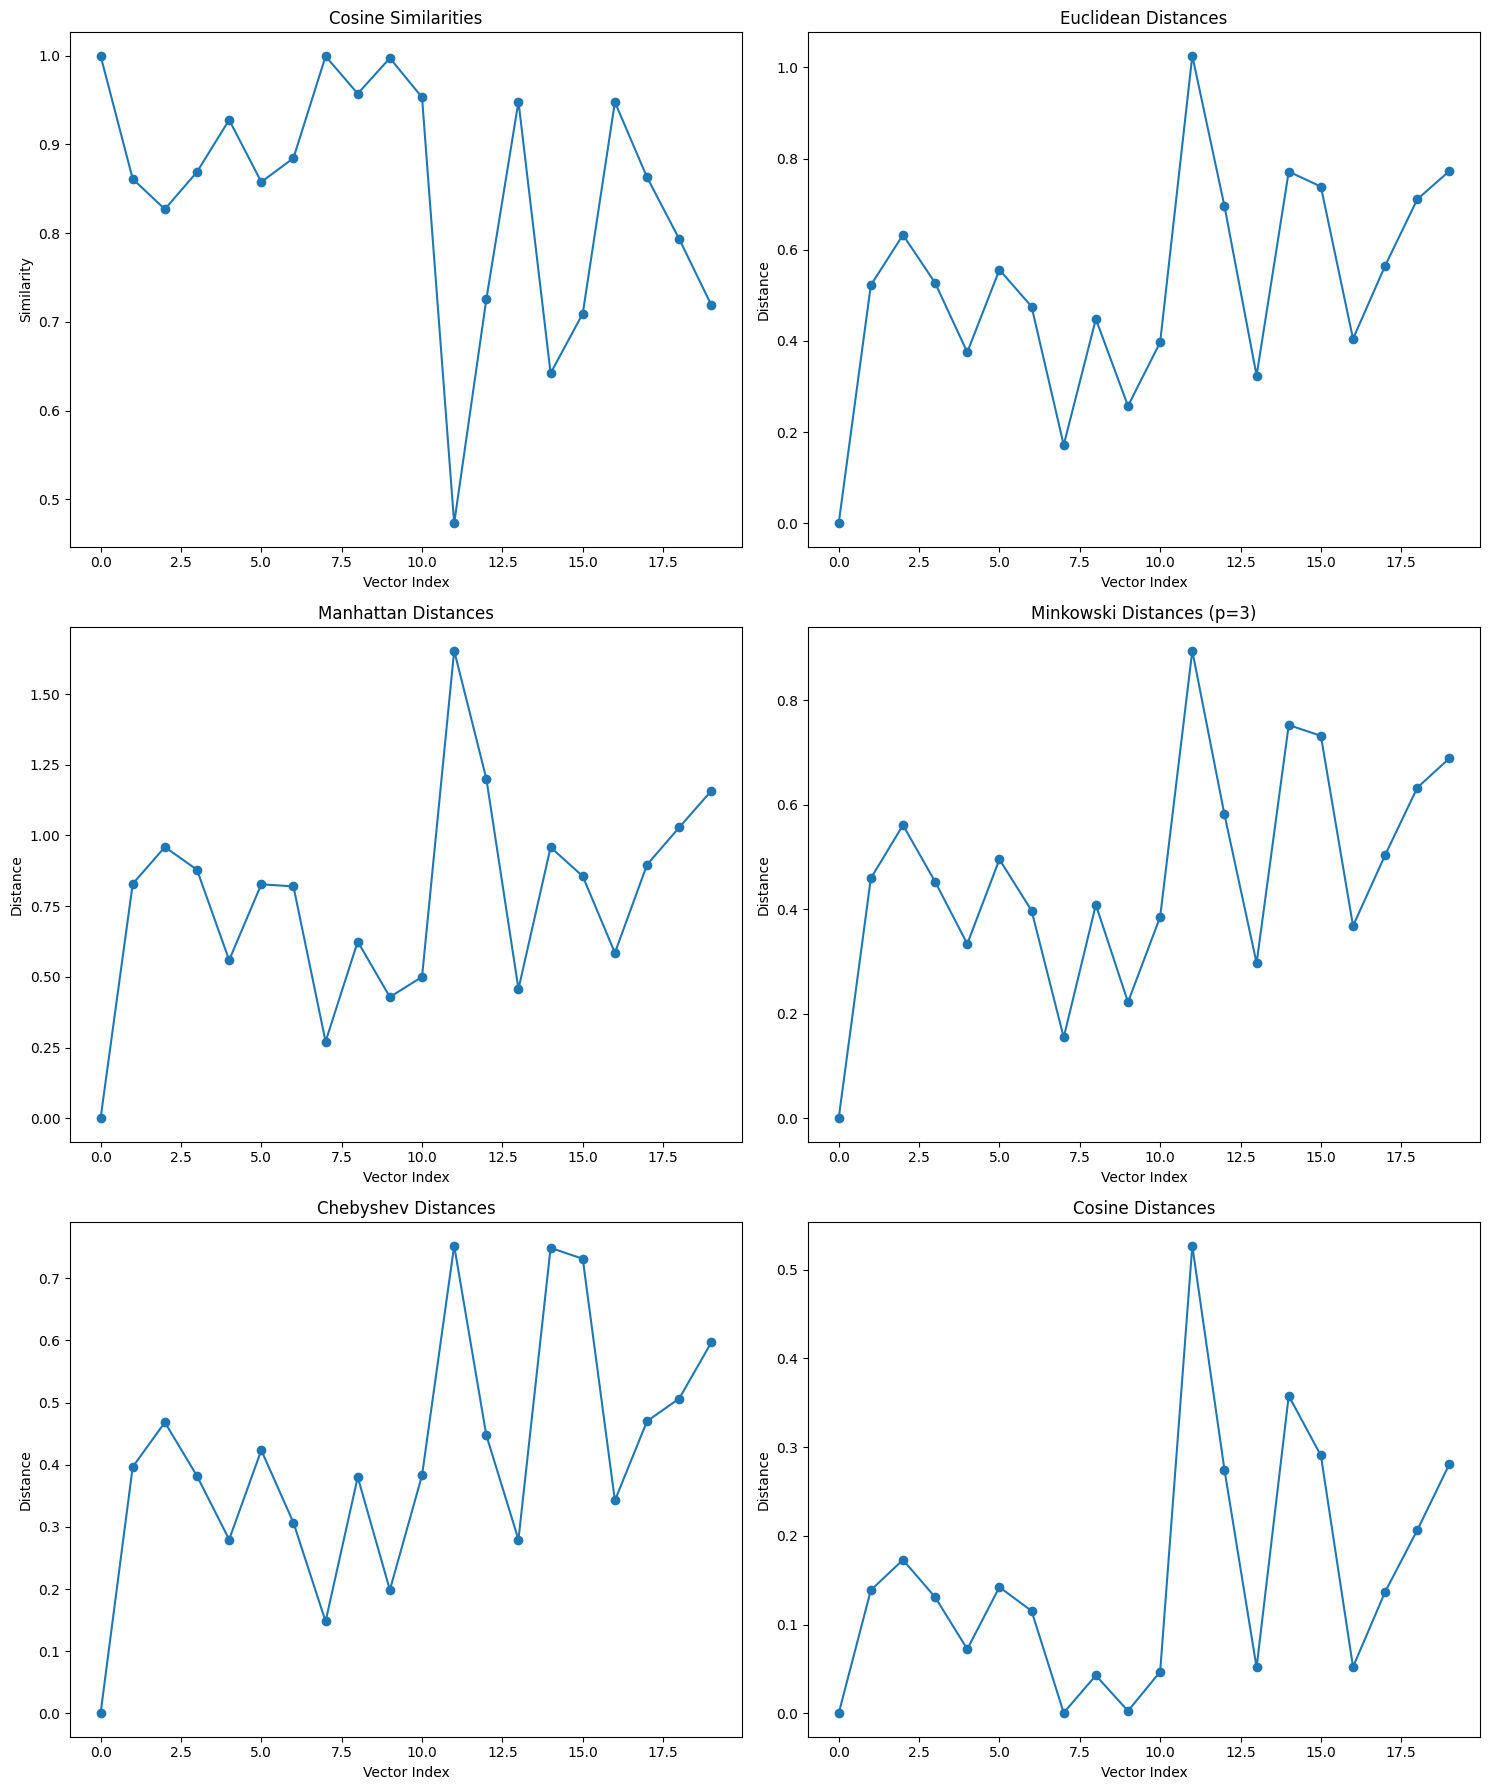

In [5]:
import matplotlib.pyplot as plt

# Number of vectors to plot
num_vectors_to_plot = 20  # Adjust this number as needed

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Plot Cosine Similarities
axs[0, 0].plot(range(num_vectors_to_plot),
               cosine_similarities[:num_vectors_to_plot], marker='o')
axs[0, 0].set_title('Cosine Similarities')
axs[0, 0].set_xlabel('Vector Index')
axs[0, 0].set_ylabel('Similarity')

# Plot Euclidean Distances
axs[0, 1].plot(range(num_vectors_to_plot),
               euclidean_distances_list[:num_vectors_to_plot], marker='o')
axs[0, 1].set_title('Euclidean Distances')
axs[0, 1].set_xlabel('Vector Index')
axs[0, 1].set_ylabel('Distance')

# Plot Manhattan Distances
axs[1, 0].plot(range(num_vectors_to_plot),
               manhattan_distances_list[:num_vectors_to_plot], marker='o')
axs[1, 0].set_title('Manhattan Distances')
axs[1, 0].set_xlabel('Vector Index')
axs[1, 0].set_ylabel('Distance')

# Plot Minkowski Distances
axs[1, 1].plot(range(num_vectors_to_plot),
               minkowski_distances_list[:num_vectors_to_plot], marker='o')
axs[1, 1].set_title('Minkowski Distances (p=3)')
axs[1, 1].set_xlabel('Vector Index')
axs[1, 1].set_ylabel('Distance')

# Plot Chebyshev Distances
axs[2, 0].plot(range(num_vectors_to_plot),
               chebyshev_distances_list[:num_vectors_to_plot], marker='o')
axs[2, 0].set_title('Chebyshev Distances')
axs[2, 0].set_xlabel('Vector Index')
axs[2, 0].set_ylabel('Distance')

# Plot Cosine Distances
axs[2, 1].plot(range(num_vectors_to_plot),
               cosine_distances_list[:num_vectors_to_plot], marker='o')
axs[2, 1].set_title('Cosine Distances')
axs[2, 1].set_xlabel('Vector Index')
axs[2, 1].set_ylabel('Distance')

# Adjust layout
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           1000 non-null   object
 1   Age                  1000 non-null   int64 
 2   Gender               1000 non-null   object
 3   AnnualIncome         1000 non-null   int64 
 4   SpendingScore        1000 non-null   int64 
 5   NumTransactions      1000 non-null   int64 
 6   AvgTransactionValue  1000 non-null   int64 
 7   TotalSpent           1000 non-null   int64 
 8   MembershipDuration   1000 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 70.4+ KB


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Load your dataset (replace with your actual dataset)
df = pd.read_csv('simulated_shopping_behavior.csv')
df.info()

# Select relevant features for clustering

features = ['Age', 'AnnualIncome', 'SpendingScore', 'NumTransactions',

            'AvgTransactionValue', 'TotalSpent', 'MembershipDuration']

df_selected = df[features]


# Handle missing values (if any)

df_selected = df_selected.dropna()


# Standardize the features

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_selected)


# Function to calculate silhouette scores for different metrics



def calculate_silhouette_scores(df_scaled, metrics):

    scores = {}

    for metric in metrics:

        if metric in ['euclidean', 'manhattan', 'cosine']:

            model = AgglomerativeClustering(

                n_clusters=4, metric=metric, linkage='complete')

        else:

            model = KMeans(n_clusters=4, random_state=42)

        labels = model.fit_predict(df_scaled)

        score = silhouette_score(df_scaled, labels, metric=metric)

        scores[metric] = score
    return scores



# Define the metrics to compare

metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']


# Calculate silhouette scores for each metric

silhouette_scores = calculate_silhouette_scores(df_scaled, metrics)


# Display the silhouette scores

print("Silhouette Scores for Different Metrics:")

for metric, score in silhouette_scores.items():

    print(f"{metric.capitalize()}: {score}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           1000 non-null   object
 1   Age                  1000 non-null   int64 
 2   Gender               1000 non-null   object
 3   AnnualIncome         1000 non-null   int64 
 4   SpendingScore        1000 non-null   int64 
 5   NumTransactions      1000 non-null   int64 
 6   AvgTransactionValue  1000 non-null   int64 
 7   TotalSpent           1000 non-null   int64 
 8   MembershipDuration   1000 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 70.4+ KB
Silhouette Scores for Different Metrics:
Euclidean: 0.07044231102499988
Manhattan: 0.07090289941381574
Minkowski: 0.14006767512979737
Chebyshev: 0.0882234100017827
Cosine: 0.0986130716772596


c:\Users\stefa\anaconda3\envs\py3aai\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\stefa\anaconda3\envs\py3aai\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

# Load your dataset (replace with your actual dataset)
df = pd.read_csv('simulated_shopping_behavior.csv')
df.info()

# Select relevant features for clustering
features = ['Age', 'AnnualIncome', 'SpendingScore', 'NumTransactions',
            'AvgTransactionValue', 'TotalSpent', 'MembershipDuration']
df_selected = df[features]

# Handle missing values (if any)
df_selected = df_selected.dropna()

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Function to calculate silhouette scores for different metrics


def calculate_silhouette_scores(df_scaled, metrics):
    scores = {}
    for metric in metrics:
        if metric in ['euclidean', 'manhattan']:
            model = AgglomerativeClustering(
                n_clusters=4, metric=metric, linkage='complete')
            labels = model.fit_predict(df_scaled)
        elif metric == 'cosine':
            dist_matrix = pairwise_distances(df_scaled, metric=metric)
            model = AgglomerativeClustering(
                n_clusters=4, affinity='precomputed', linkage='complete')
            labels = model.fit_predict(dist_matrix)
        elif metric == 'minkowski':
            model = KMeans(n_clusters=4, random_state=42)
            labels = model.fit_predict(df_scaled)
        elif metric == 'chebyshev':
            dist_matrix = pairwise_distances(df_scaled, metric=metric)
            model = AgglomerativeClustering(
                n_clusters=4, affinity='precomputed', linkage='complete')
            labels = model.fit_predict(dist_matrix)
        else:
            raise ValueError(f"Metric {metric} not supported.")

        score = silhouette_score(df_scaled, labels, metric='euclidean')
        scores[metric] = score
    return scores


# Define the metrics to compare
#metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']

metrics = ['euclidean', 'manhattan', 'minkowski']

# Calculate silhouette scores for each metric
silhouette_scores = calculate_silhouette_scores(df_scaled, metrics)

# Display the silhouette scores
print("Silhouette Scores for Different Metrics:")
for metric, score in silhouette_scores.items():
    print(f"{metric.capitalize()}: {score}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           1000 non-null   object
 1   Age                  1000 non-null   int64 
 2   Gender               1000 non-null   object
 3   AnnualIncome         1000 non-null   int64 
 4   SpendingScore        1000 non-null   int64 
 5   NumTransactions      1000 non-null   int64 
 6   AvgTransactionValue  1000 non-null   int64 
 7   TotalSpent           1000 non-null   int64 
 8   MembershipDuration   1000 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 70.4+ KB
Silhouette Scores for Different Metrics:
Euclidean: 0.07044231102499988
Manhattan: 0.065179148867521
Minkowski: 0.14006767512979737


c:\Users\stefa\anaconda3\envs\py3aai\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CustomerID           1000 non-null   object
 1   Age                  1000 non-null   int64 
 2   Gender               1000 non-null   object
 3   AnnualIncome         1000 non-null   int64 
 4   SpendingScore        1000 non-null   int64 
 5   NumTransactions      1000 non-null   int64 
 6   AvgTransactionValue  1000 non-null   int64 
 7   TotalSpent           1000 non-null   int64 
 8   MembershipDuration   1000 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 70.4+ KB
Silhouette Scores for Different Metrics:
Euclidean: 0.33217588398298437
Manhattan: 0.36076354946283173
Cosine: 0.4228253827526757


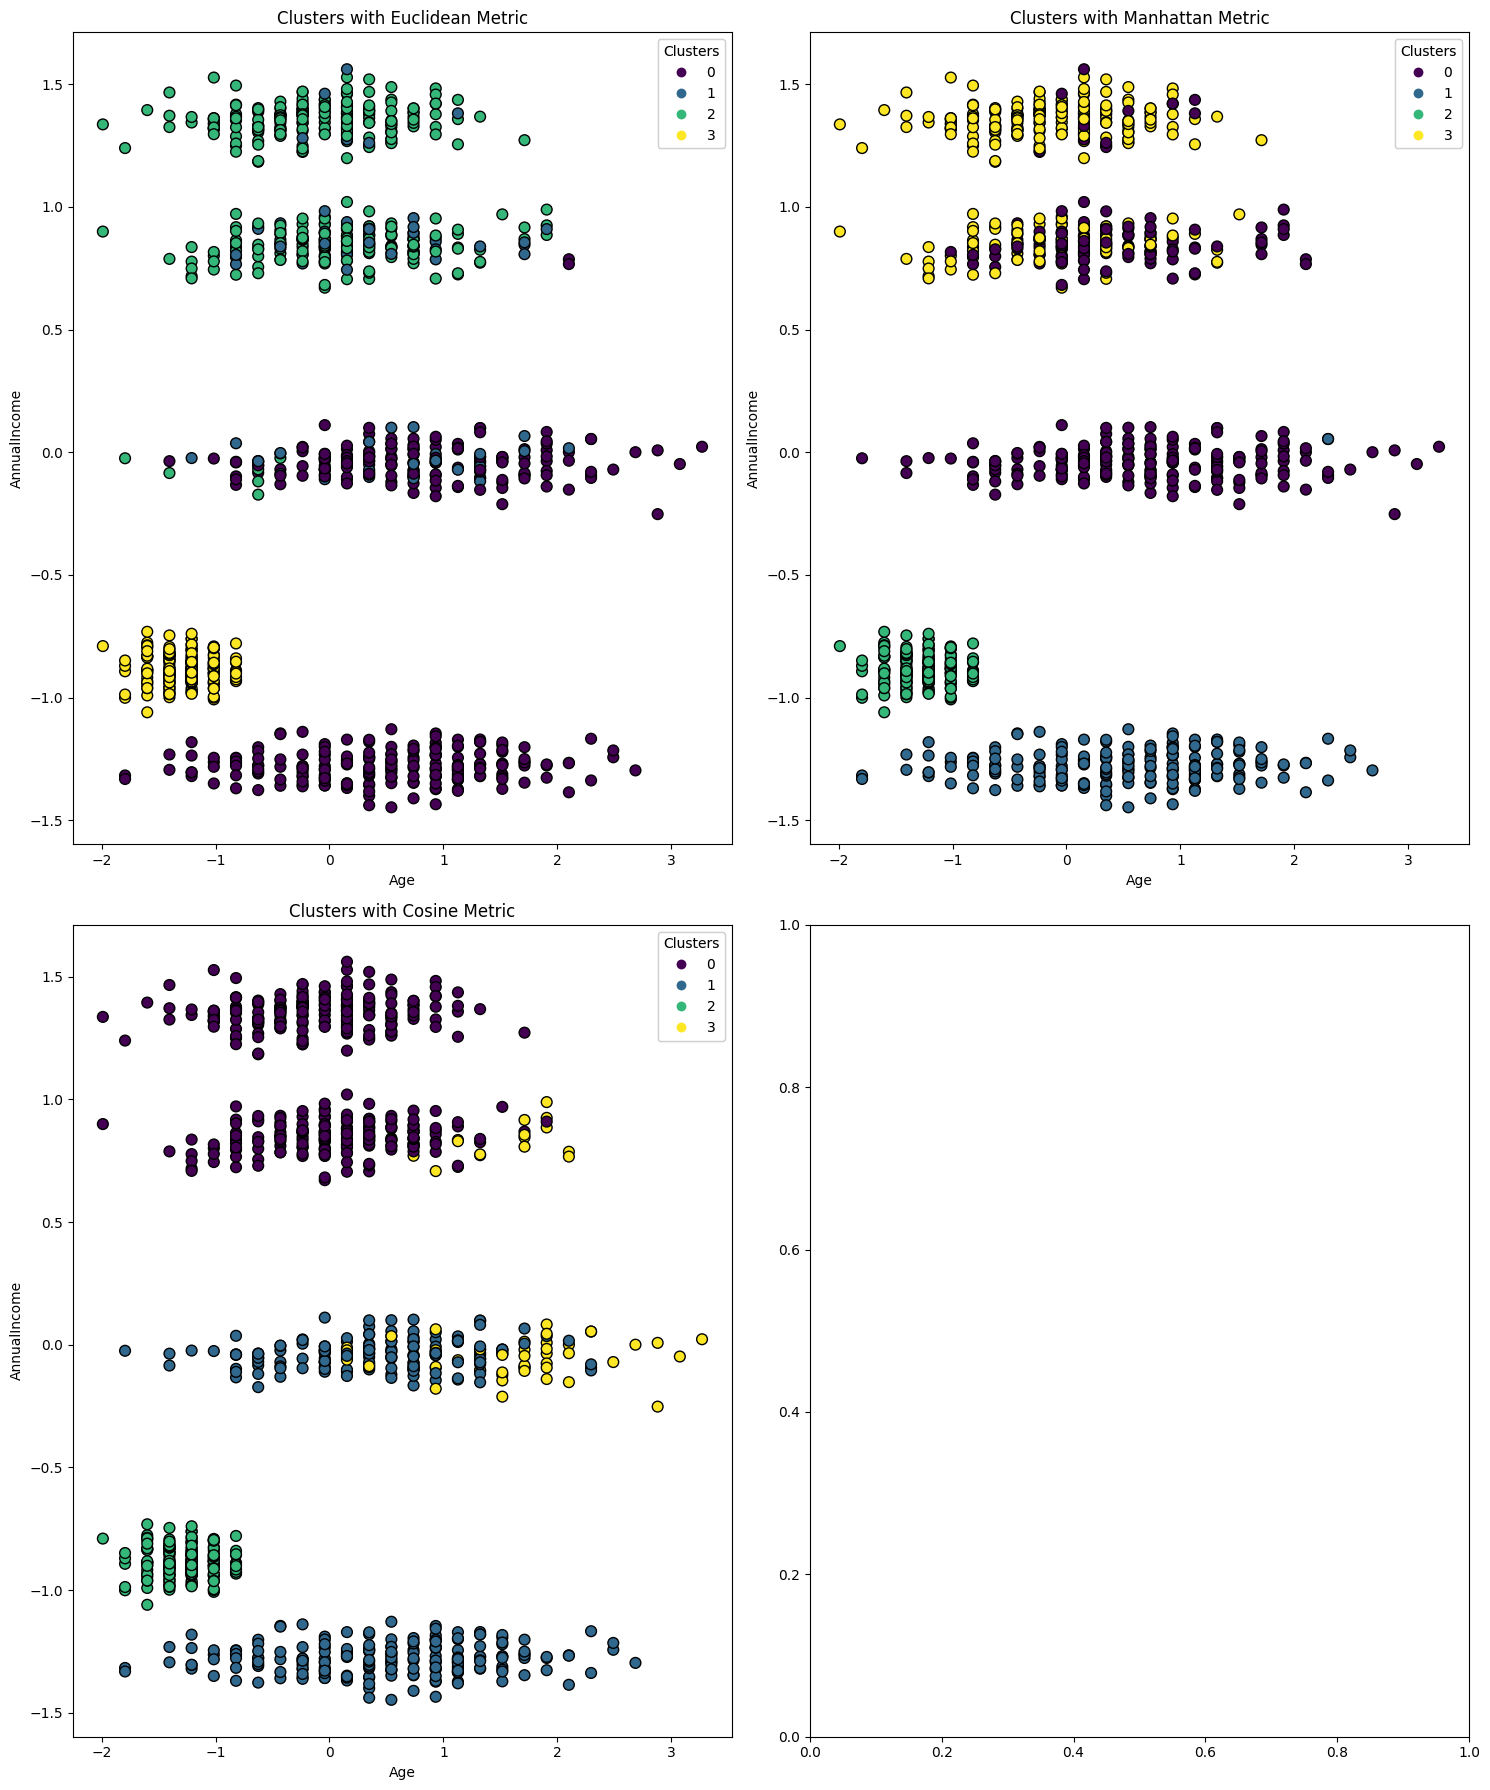

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load your dataset (replace with your actual dataset)
df = pd.read_csv('simulated_customer_data1.csv')
df.info()

# Select relevant features for clustering
features = ['Age', 'AnnualIncome', 'SpendingScore', 'NumTransactions',
            'AvgTransactionValue', 'TotalSpent', 'MembershipDuration']
df_selected = df[features]

# Handle missing values (if any)
df_selected = df_selected.dropna()

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Function to calculate silhouette scores and cluster labels for different metrics


def calculate_silhouette_scores_and_labels(df_scaled, metrics):
    scores = {}
    labels_dict = {}

    for metric in metrics:
        if metric in ['euclidean', 'manhattan', 'cosine']:
            model = AgglomerativeClustering(
                n_clusters=4, metric=metric, linkage='complete')
        else:
            model = KMeans(n_clusters=4, random_state=42)

        labels = model.fit_predict(df_scaled)
        score = silhouette_score(df_scaled, labels, metric=metric)
        scores[metric] = score
        labels_dict[metric] = labels

    return scores, labels_dict


# Define the metrics to compare
# Updated the list to remove unsupported metrics
metrics = ['euclidean', 'manhattan', 'cosine']
#metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']

# Calculate silhouette scores and cluster labels for each metric
silhouette_scores, labels_dict = calculate_silhouette_scores_and_labels(
    df_scaled, metrics)

# Display the silhouette scores
print("Silhouette Scores for Different Metrics:")
for metric, score in silhouette_scores.items():
    print(f"{metric.capitalize()}: {score}")

# Plot the clusters for each metric
fig, axes = plt.subplots(2, 2, figsize=(15, 18))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    scatter = ax.scatter(df_scaled[:, 0], df_scaled[:, 1],
                         c=labels_dict[metric], cmap='viridis', edgecolor='k', s=60)
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_title(f"Clusters with {metric.capitalize()} Metric")
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])

plt.tight_layout()
plt.show()

c:\Users\stefa\anaconda3\envs\py3aai\Lib\site-packages\sklearn\cluster\_agglomerative.py:586: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
c:\Users\stefa\anaconda3\envs\py3aai\Lib\site-packages\sklearn\cluster\_agglomerative.py:586: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Scores for Different Metrics:
Euclidean: 0.33217588398298437
Manhattan: 0.36076354946283173
Minkowski: 0.3412357218509094
Chebyshev: 0.2398374959197669
Cosine: 0.4228253827526757


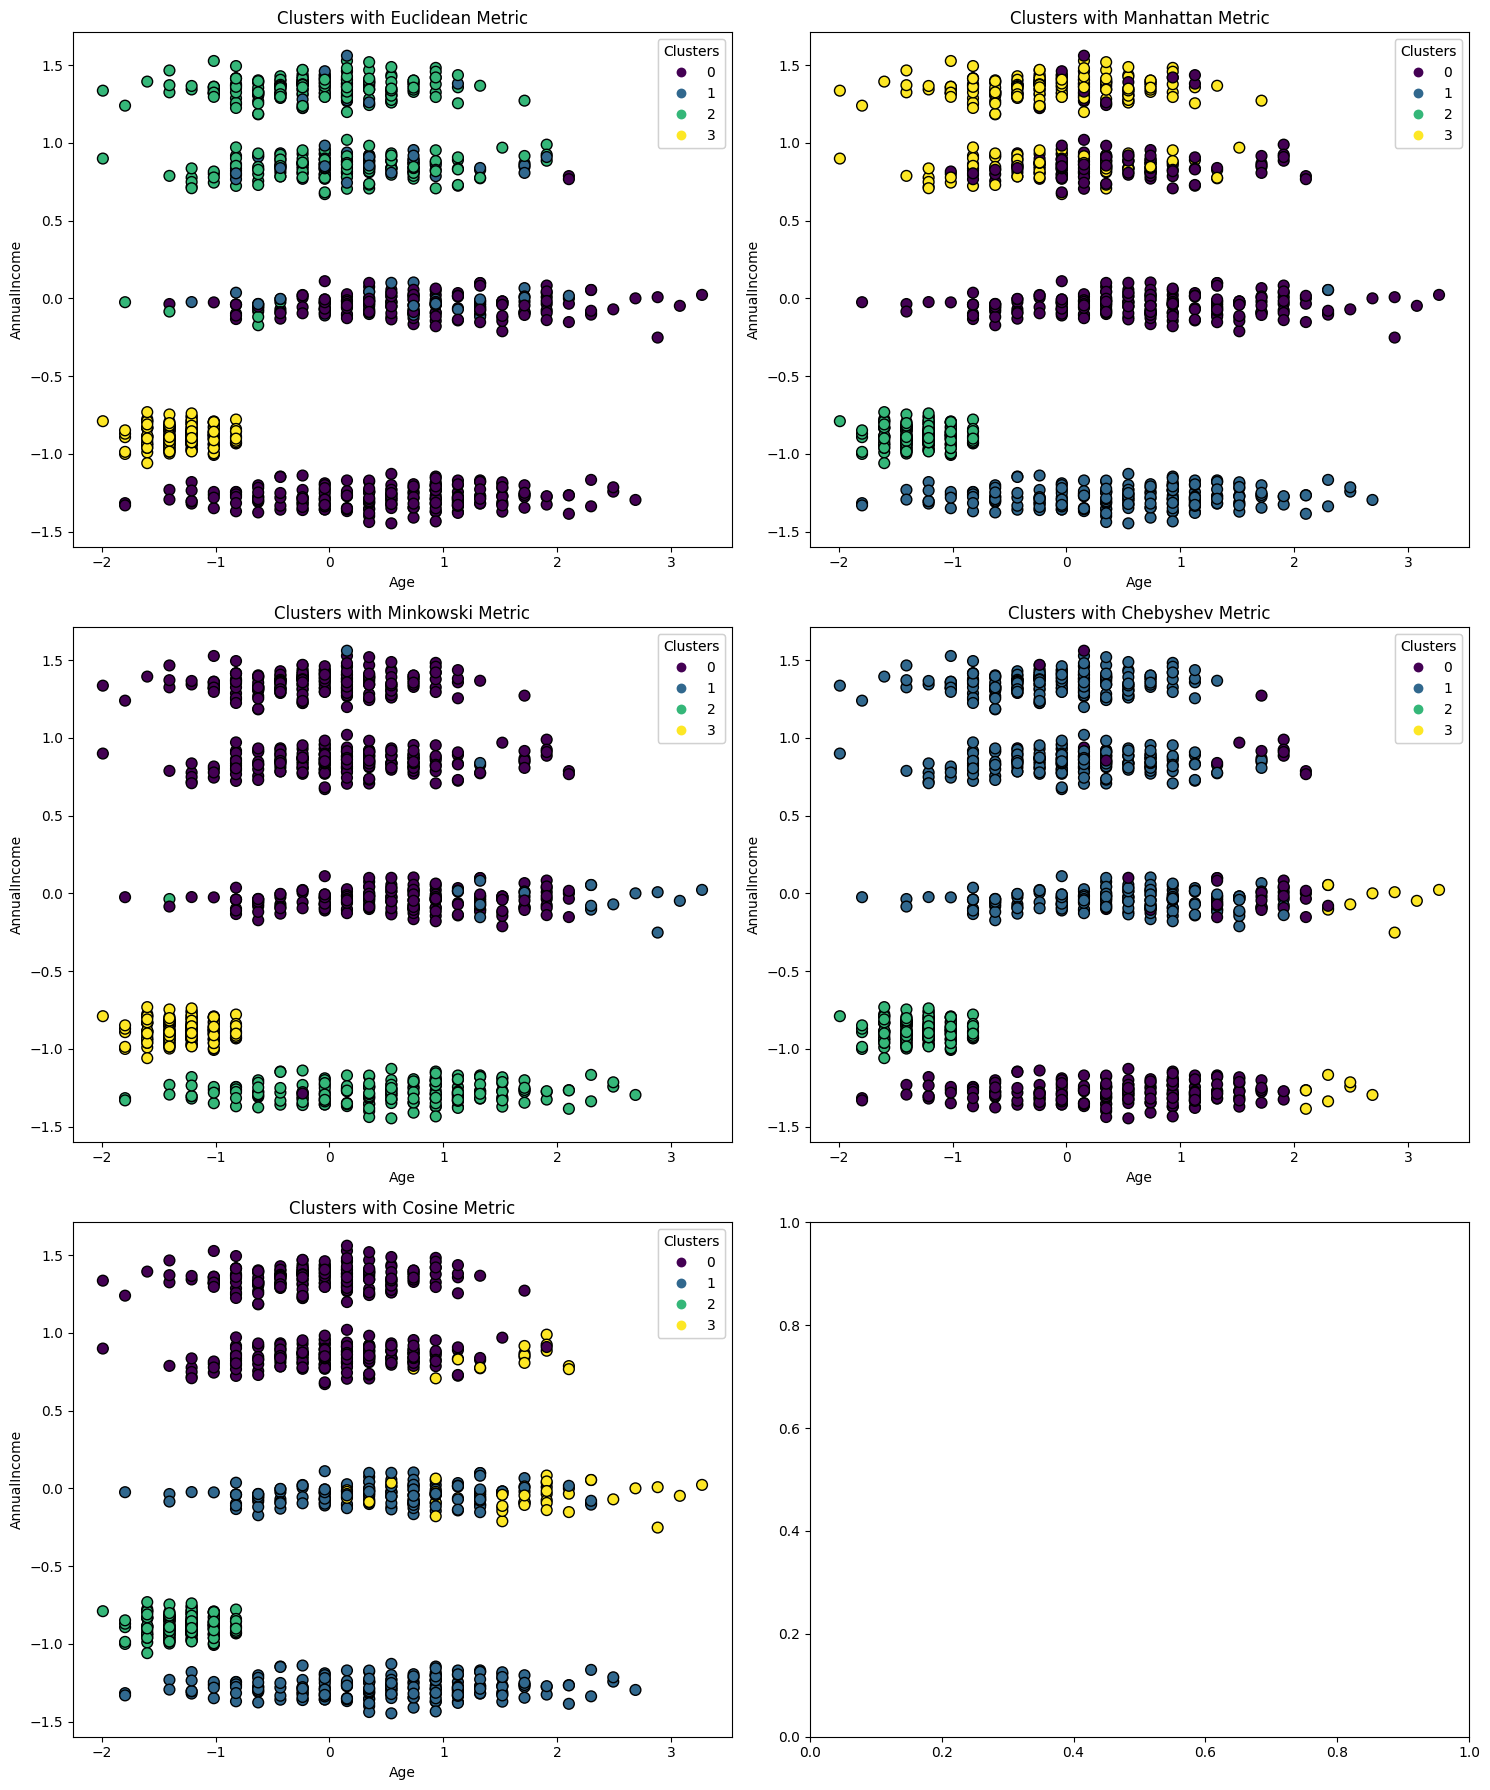

In [12]:

# Load the simulated customer data
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd



# Load the simulated customer data
df = pd.read_csv('simulated_customer_data1.csv')

# Select relevant features for clustering
features = ['Age', 'AnnualIncome', 'SpendingScore', 'NumTransactions',
            'AvgTransactionValue', 'TotalSpent', 'MembershipDuration']
df_selected = df[features]

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Function to calculate silhouette scores and cluster labels for different metrics


def calculate_silhouette_scores_and_labels(df_scaled, metrics):
    scores = {}
    labels_dict = {}

    for metric in metrics:
        if metric in ['euclidean', 'manhattan', 'cosine']:
            model = AgglomerativeClustering(
                n_clusters=4, metric=metric, linkage='complete')
            labels = model.fit_predict(df_scaled)
        elif metric in ['minkowski', 'chebyshev']:
            dist_matrix = squareform(pdist(df_scaled, metric=metric))
            model = AgglomerativeClustering(n_clusters=4, linkage='complete')
            labels = model.fit_predict(dist_matrix)
        else:
            model = KMeans(n_clusters=4, random_state=42)
            labels = model.fit_predict(df_scaled)

        score = silhouette_score(df_scaled, labels, metric=metric)
        scores[metric] = score
        labels_dict[metric] = labels

    return scores, labels_dict


# Define the metrics to compare
metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosine']

# Calculate silhouette scores and cluster labels for each metric
silhouette_scores, labels_dict = calculate_silhouette_scores_and_labels(
    df_scaled, metrics)

# Display the silhouette scores
print("Silhouette Scores for Different Metrics:")
for metric, score in silhouette_scores.items():
    print(f"{metric.capitalize()}: {score}")

# Plot the clusters for each metric
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    scatter = ax.scatter(df_scaled[:, 0], df_scaled[:, 1],
                         c=labels_dict[metric], cmap='viridis', edgecolor='k', s=60)
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    ax.set_title(f"Clusters with {metric.capitalize()} Metric")
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])

plt.tight_layout()
plt.show()

Best Parameters: Number of Clusters = 2, Linkage = ward
Best Silhouette Score: 0.43041168940864466


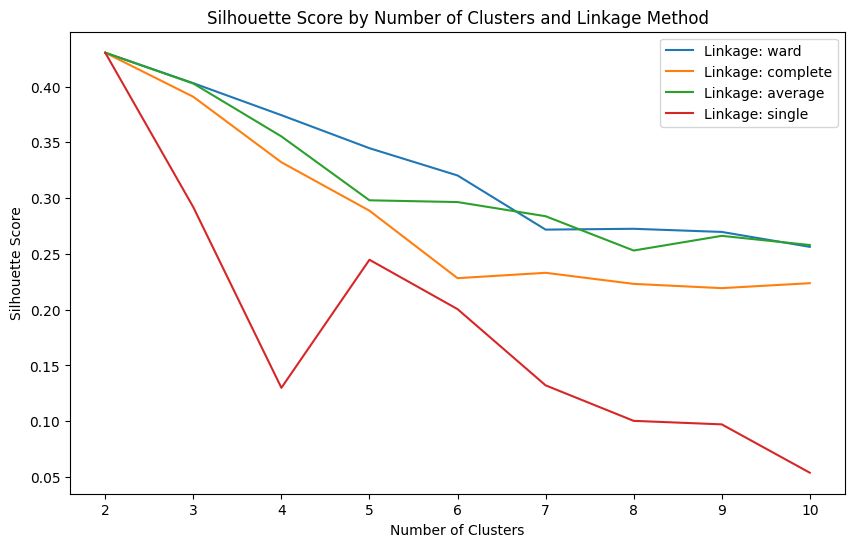

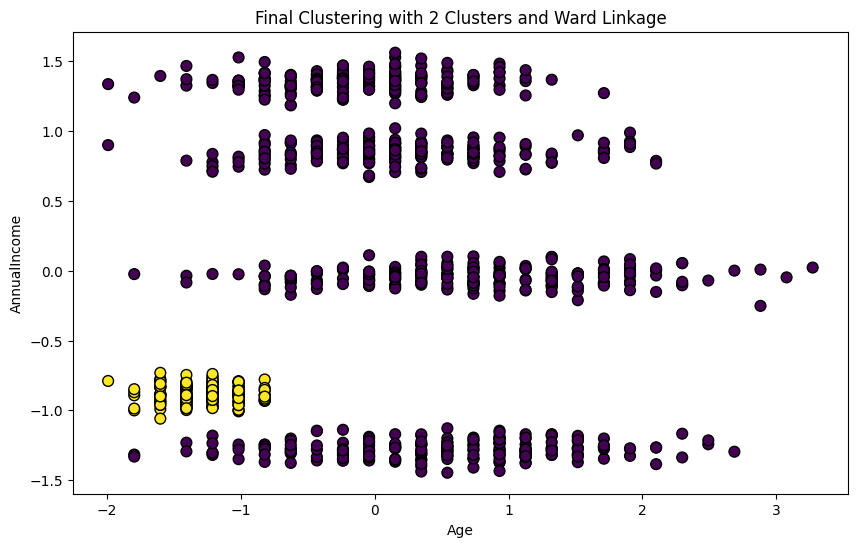

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the simulated customer data
df = pd.read_csv('simulated_customer_data1.csv')

# Select relevant features for clustering
features = ['Age', 'AnnualIncome', 'SpendingScore', 'NumTransactions',
            'AvgTransactionValue', 'TotalSpent', 'MembershipDuration']
df_selected = df[features]

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Function to calculate silhouette scores for different numbers of clusters and linkage methods


def optimize_clustering(df_scaled):
    best_score = -1
    best_params = None
    results = []

    for n_clusters in range(2, 11):  # Test clusters from 2 to 10
        for linkage in ['ward', 'complete', 'average', 'single']:
            model = AgglomerativeClustering(
                n_clusters=n_clusters, linkage=linkage)
            labels = model.fit_predict(df_scaled)
            score = silhouette_score(df_scaled, labels)
            results.append((n_clusters, linkage, score))

            if score > best_score:
                best_score = score
                best_params = (n_clusters, linkage)

    return best_params, best_score, results


# Optimize clustering
best_params, best_score, results = optimize_clustering(df_scaled)

# Display the best parameters
print(
    f"Best Parameters: Number of Clusters = {best_params[0]}, Linkage = {best_params[1]}")
print(f"Best Silhouette Score: {best_score}")

# Plot the silhouette scores for different parameters
fig, ax = plt.subplots(figsize=(10, 6))
results_df = pd.DataFrame(
    results, columns=['n_clusters', 'linkage', 'silhouette_score'])
for linkage in results_df['linkage'].unique():
    subset = results_df[results_df['linkage'] == linkage]
    ax.plot(subset['n_clusters'], subset['silhouette_score'],
            label=f'Linkage: {linkage}')

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score by Number of Clusters and Linkage Method')
ax.legend()
plt.show()

# Final clustering using the best parameters
final_model = AgglomerativeClustering(
    n_clusters=best_params[0], linkage=best_params[1])
final_labels = final_model.fit_predict(df_scaled)

# Plot the final clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1],
            c=final_labels, cmap='viridis', edgecolor='k', s=60)
plt.title(
    f"Final Clustering with {best_params[0]} Clusters and {best_params[1].capitalize()} Linkage")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

In [ ]:
from py2neo import Graph
import pandas as pd

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "onekenoby"))

# Query to get all nodes and relationships
nodes_query = """
MATCH (n)
RETURN id(n) as id, labels(n) as labels, n.name as name
"""

relationships_query = """
MATCH ()-[r]->()
RETURN id(startNode(r)) as source, id(endNode(r)) as target, type(r) as type
"""

nodes = graph.run(nodes_query).to_data_frame()
relationships = graph.run(relationships_query).to_data_frame()

In [ ]:
import networkx as nx
import plotly.graph_objects as go

# Create a networkx graph
G = nx.Graph()

# Add nodes
for index, row in nodes.iterrows():
    G.add_node(row['id'], label=row['labels'][0], name=row['name'])

# Add edges
for index, row in relationships.iterrows():
    G.add_edge(row['source'], row['target'], label=row['type'])

# Get positions for the nodes in 3D
pos = nx.spring_layout(G, dim=3, seed=42)

# Extract the coordinates
x_nodes = [pos[k][0] for k in G.nodes()]
y_nodes = [pos[k][1] for k in G.nodes()]
z_nodes = [pos[k][2] for k in G.nodes()]

# Create edge coordinates
x_edges = []
y_edges = []
z_edges = []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]
    z_edges += [pos[edge[0]][2], pos[edge[1]][2], None]

# Create the 3D plot
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter3d(
    x=x_edges, y=y_edges, z=z_edges,
    mode='lines',
    line=dict(color='black', width=1),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(symbol='circle', size=5, color='blue'),
    text=[f"{d['label']}: {d['name']}" for i, d in G.nodes(data=True)],
    hoverinfo='text'
))

# Set plot layout with increased height
fig.update_layout(
    title="3D Graph Visualization",
    showlegend=False,
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    ),
    width=1200,  # Width of the plot
    height=1000  # Height of the plot (double the default)
)

# Show the plot
fig.show()

In [ ]:
import networkx as nx
import plotly.graph_objects as go

# Create a networkx graph
G = nx.Graph()

# Add nodes
for index, row in nodes.iterrows():
    G.add_node(row['id'], label=row['labels'][0], name=row['name'])

# Add edges
for index, row in relationships.iterrows():
    G.add_edge(row['source'], row['target'], label=row['type'])

# Get positions for the nodes in 3D
pos = nx.spring_layout(G, dim=3, seed=42)

# Extract the coordinates
x_nodes = [pos[k][0] for k in G.nodes()]
y_nodes = [pos[k][1] for k in G.nodes()]
z_nodes = [pos[k][2] for k in G.nodes()]

# Create edge coordinates
x_edges = []
y_edges = []
z_edges = []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]
    z_edges += [pos[edge[0]][2], pos[edge[1]][2], None]

# Create the 3D plot
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter3d(
    x=x_edges, y=y_edges, z=z_edges,
    mode='lines',
    line=dict(color='black', width=1),
    hoverinfo='none'
))

# Add nodes with labels
fig.add_trace(go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers+text',
    marker=dict(symbol='circle', size=5, color='blue'),
    text=[f"{d['label']}: {d['name']}" for i, d in G.nodes(data=True)],
    hoverinfo='text',
    textposition='top center'  # Position of the labels
))

# Set plot layout with increased height and enable panning and other controls
fig.update_layout(
    title="3D Graph Visualization",
    showlegend=False,
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    ),
    width=1200,  # Width of the plot
    height=800,  # Height of the plot (double the default)
    scene_camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.25, y=1.25, z=1.25)
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    uirevision=True,
)

# Show the plot
fig.show()